In [21]:
import sys
!{sys.executable} -m pip install numpy matplotlib scipy scikit-learn pandas

In [22]:
import os
import sys  

sys.path.insert(0, os.path.dirname(os.getcwd()) + "/code/")

import helper_functions
from importlib import reload

from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.integrate import quad

import matplotlib.pyplot as plt
%matplotlib inline

import json
import fnmatch
import scipy

from sklearn.metrics import auc
from sklearn.covariance import EllipticEnvelope

## Change Directory

In [23]:
os.chdir(os.path.dirname(os.getcwd()) + "/ambient")
print(os.getcwd())

/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/data/ambient


In [24]:
# List the files in the 'data' folder
[file for file in os.listdir(".") if "dyno" in file]

['ambient_dyno_exercise_all_bits.log',
 'ambient_dyno_reverse.log',
 'ambient_dyno_drive_basic_short.log',
 'ambient_dyno_drive_radio_infotainment.log',
 'ambient_dyno_drive_winter.log',
 'ambient_dyno_drive_extended_short.log',
 'ambient_dyno_drive_extended_long.log',
 'ambient_dyno_drive_basic_long.log',
 'ambient_dyno_idle_radio_infotainment.log',
 'ambient_dyno_drive_benign_anomaly.log']

## Load Training Data

Aggregate ambient data for training in a single file. Here we considered only data generated in dyno conditions. 

In [25]:
df_aggregation = []

for file_name in os.listdir("."):
    
    if "dyno" in file_name:
        
        print(file_name)
        df = helper_functions.make_can_df(file_name)
        df = helper_functions.add_time_diff_per_aid_col(df)
        print(df.shape)
        # print(df.dtypes)
             
        df_aggregation.append(df)

# Concatenate all training datasets on the dyno
df_training = pd.concat(df_aggregation)
df_training = df_training[["time", "aid", "time_diffs"]]
display(df_training)

ambient_dyno_exercise_all_bits.log
(4135914, 4)
ambient_dyno_reverse.log
(115180, 4)
ambient_dyno_drive_basic_short.log
(996375, 4)
ambient_dyno_drive_radio_infotainment.log
(873911, 4)
ambient_dyno_drive_winter.log
(106832, 4)
ambient_dyno_drive_extended_short.log
(741466, 4)
ambient_dyno_drive_extended_long.log
(1334942, 4)
ambient_dyno_drive_basic_long.log
(2802326, 4)
ambient_dyno_idle_radio_infotainment.log
(1472991, 4)
ambient_dyno_drive_benign_anomaly.log
(720822, 4)


,time,aid,time_diffs
192,0.313438,6,0.210577
984,1.307807,6,0.994369
1784,2.312546,6,1.004739
2581,3.316765,6,1.004219
3361,4.291507,6,0.974742
...,...,...,...
770462,455.992919,1788,0.099990
770703,456.092889,1788,0.099970
770941,456.192957,1788,0.100068
771132,456.292914,1788,0.099957


## Save Aggregated Training Set

In [26]:
df_training.to_csv("aggregated_training_data.csv", index=False)

## Loading Aggregated Training Data

In [27]:
df_training = pd.read_csv("aggregated_training_data.csv")
display(df_training)

# df_training = helper_functions.make_can_df("ambient_dyno_exercise_all_bits.log") 
# df_training = helper_functions.make_can_df("ambient_dyno_drive_basic_long.log") # Works well
# df_training = helper_functions.add_time_diff_per_aid_col(df_training)

,time,aid,time_diffs
0,0.313438,6,0.210577
1,1.307807,6,0.994369
2,2.312546,6,1.004739
3,3.316765,6,1.004219
4,4.291507,6,0.974742
...,...,...,...
13300754,455.992919,1788,0.099990
13300755,456.092889,1788,0.099970
13300756,456.192957,1788,0.100068
13300757,456.292914,1788,0.099957


## Train Model

In [28]:
reload(helper_functions)

# Begin training on this dataset
# training_dict has aids as keys and dictionaries containing mu, std, kde, and gaussian as items
training_dict = {}
#cc = 0
for aid in tqdm(df_training.aid.unique()):
    #cc += 1
    #print (f'aid {cc} of 128')
    print("aid: ", aid)
    
    training_dict[aid] = helper_functions.train(df_training, aid)
    training_dict[aid]["y_thresholds_kde"] = {}
    training_dict[aid]["y_thresholds_gauss"] = {}
    
    #print("\n")


  1%|          | 1/105 [00:00<00:13,  7.95it/s]

aid:  6
before:  6340
outliers:  1 0.015772870662460567
after:  6339
aid:  14
before:  580454


  2%|▏         | 2/105 [00:00<00:29,  3.46it/s]

outliers:  59 0.010164457476389171
after:  580395
aid:  37
before:  7656
outliers:  1 0.013061650992685475
after:  7655
aid:  51
before:  570718


  7%|▋         | 7/105 [00:01<00:12,  7.90it/s]

outliers:  58 0.010162637239407203
after:  570660
aid:  58
before:  11572
outliers:  2 0.017283097131005877
after:  11570
aid:  60
before:  64264
outliers:  7 0.010892568156355035
after:  64257
aid:  61
before:  57860
outliers:  6 0.010369858278603527
after:  57854
aid:  65
before:  6441
outliers:  1 0.01552553951249806
after:  6440
aid:  117
before:  11569
outliers:  2 0.017287578874578616
after:  11567
aid:  167
before:  578687


 10%|▉         | 10/105 [00:01<00:11,  8.01it/s]

outliers:  58 0.010022689294903808
after:  578629
aid:  186
before:  160636
outliers:  17 0.010582932841953236
after:  160619
aid:  192
before:  285343


 11%|█▏        | 12/105 [00:01<00:11,  7.78it/s]

outliers:  29 0.01016320708761035
after:  285314
aid:  204
before:  6419
outliers:  1 0.015578750584203147
after:  6418
aid:  208
before:  570727


 16%|█▌        | 17/105 [00:02<00:09,  9.71it/s]

outliers:  58 0.010162476981113562
after:  570669
aid:  215
before:  57864
outliers:  6 0.010369141435089175
after:  57858
aid:  241
before:  12850
outliers:  2 0.01556420233463035
after:  12848
aid:  244
before:  55588
outliers:  6 0.010793696481254948
after:  55582
aid:  248
before:  6338
outliers:  1 0.015777847901546228
after:  6337
aid:  253
before:  6418
outliers:  1 0.015581177937052042
after:  6417
aid:  263


 19%|█▉        | 20/105 [00:02<00:07, 10.64it/s]

before:  321288
outliers:  33 0.010271158586688579
after:  321255
aid:  293
before:  556856


 21%|██        | 22/105 [00:02<00:09,  8.88it/s]

outliers:  56 0.010056459838809316
after:  556800
aid:  300
before:  6329
outliers:  1 0.015800284405119294
after:  6328
aid:  304
before:  58041
outliers:  6 0.010337520028945056
after:  58035
aid:  339
before:  285366


 23%|██▎       | 24/105 [00:02<00:09,  8.99it/s]

outliers:  29 0.010162387950912162
after:  285337
aid:  354
before:  289339
outliers:  29 0.01002284517469128
after:  289310
aid:  403


 25%|██▍       | 26/105 [00:03<00:10,  7.65it/s]

before:  317809
outliers:  32 0.0100689407788955
after:  317777
aid:  412
before:  285355


 30%|██▉       | 31/105 [00:03<00:06, 11.36it/s]

outliers:  29 0.01016277969546705
after:  285326
aid:  420
before:  6499
outliers:  1 0.015386982612709647
after:  6498
aid:  426
before:  6339
outliers:  1 0.015775358889414733
after:  6338
aid:  452
before:  25704
outliers:  3 0.011671335200746966
after:  25701
aid:  458
before:  57859
outliers:  6 0.010370037504968977
after:  57853
aid:  470
before:  64334


 32%|███▏      | 34/105 [00:03<00:05, 13.57it/s]

outliers:  7 0.010880716262007647
after:  64327
aid:  485
before:  6425
outliers:  1 0.01556420233463035
after:  6424
aid:  519
before:  64388
outliers:  7 0.010871590979685656
after:  64381
aid:  526
before:  317809


 34%|███▍      | 36/105 [00:03<00:05, 12.41it/s]

outliers:  32 0.0100689407788955
after:  317777
aid:  541
before:  6574
outliers:  1 0.015211439002129602
after:  6573
aid:  560
before:  317799
outliers:  32 0.010069257612516088
after:  317767


 36%|███▌      | 38/105 [00:04<00:05, 11.33it/s]

aid:  569
before:  57867
outliers:  6 0.010368603867489242
after:  57861
aid:  622
before:  62900
outliers:  7 0.011128775834658187
after:  62893
aid:  627
before:  6426
outliers:  1 0.01556178026766262
after:  6425
aid:  628
before:  285348


 39%|███▉      | 41/105 [00:04<00:05, 11.70it/s]

outliers:  29 0.01016302900318208
after:  285319
aid:  631
before:  3850
outliers:  1 0.025974025974025976
after:  3849
aid:  640
before:  27983
outliers:  3 0.010720794768252153
after:  27980
aid:  651
before:  289339


 44%|████▍     | 46/105 [00:04<00:04, 12.78it/s]

outliers:  29 0.01002284517469128
after:  289310
aid:  661
before:  190237
outliers:  20 0.010513201953352922
after:  190217
aid:  663
before:  13432
outliers:  2 0.014889815366289458
after:  13430
aid:  675
before:  57867
outliers:  6 0.010368603867489242
after:  57861
aid:  676


 50%|████▉     | 52/105 [00:05<00:03, 17.57it/s]

before:  25692
outliers:  3 0.011676786548341896
after:  25689
aid:  683
before:  6328
outliers:  1 0.01580278128950695
after:  6327
aid:  692
before:  68404
outliers:  7 0.010233319688907082
after:  68397
aid:  695
before:  6351
outliers:  1 0.01574555188159345
after:  6350
aid:  705
before:  53033
outliers:  6 0.011313710331303151
after:  53027
aid:  722
before:  57854


 51%|█████▏    | 54/105 [00:05<00:02, 17.79it/s]

outliers:  6 0.010370933729733467
after:  57848
aid:  727
before:  57066
outliers:  6 0.010514141520344864
after:  57060
aid:  737
before:  289349


 55%|█████▌    | 58/105 [00:05<00:03, 15.08it/s]

outliers:  29 0.010022498781747992
after:  289320
aid:  738
before:  58043
outliers:  6 0.010337163826818048
after:  58037
aid:  778
before:  12193
outliers:  2 0.01640285409661281
after:  12191
aid:  813
before:  128516
outliers:  13 0.010115472003485948
after:  128503
aid:  837
before:  58043
outliers:  6 0.010337163826818048
after:  58037
aid:  852
before:  578696


 57%|█████▋    | 60/105 [00:05<00:05,  8.97it/s]

outliers:  58 0.010022533419964886
after:  578638
aid:  870
before:  317804


 59%|█████▉    | 62/105 [00:06<00:05,  8.14it/s]

outliers:  32 0.010069099193213428
after:  317772
aid:  881
before:  6493
outliers:  1 0.015401201293700909
after:  6492
aid:  930
before:  3852
outliers:  1 0.02596053997923157
after:  3851
aid:  953
before:  6322
outliers:  1 0.015817779183802595
after:  6321
aid:  961
before:  222705


 64%|██████▍   | 67/105 [00:06<00:03, 11.15it/s]

outliers:  23 0.010327563368581757
after:  222682
aid:  996
before:  57056
outliers:  6 0.010515984296130118
after:  57050
aid:  1031
before:  57855
outliers:  6 0.010370754472387866
after:  57849
aid:  1049
before:  12553
outliers:  2 0.01593244642714889
after:  12551
aid:  1072
before:  58043


 67%|██████▋   | 70/105 [00:06<00:03, 10.84it/s]

outliers:  6 0.010337163826818048
after:  58037
aid:  1076
before:  317804
outliers:  32 0.010069099193213428
after:  317772
aid:  1124


 69%|██████▊   | 72/105 [00:06<00:02, 12.18it/s]

before:  63556
outliers:  7 0.011013908993643401
after:  63549
aid:  1175
before:  57855
outliers:  6 0.010370754472387866
after:  57849
aid:  1176
before:  317799


 73%|███████▎  | 77/105 [00:07<00:01, 14.03it/s]

outliers:  32 0.010069257612516088
after:  317767
aid:  1225
before:  64340
outliers:  7 0.010879701585327946
after:  64333
aid:  1227
before:  27825
outliers:  3 0.01078167115902965
after:  27822
aid:  1255
before:  57069
outliers:  6 0.010513588813541502
after:  57063
aid:  1262
before:  5785
outliers:  1 0.01728608470181504
after:  5784
aid:  1277
before:  115725


 75%|███████▌  | 79/105 [00:07<00:01, 14.78it/s]

outliers:  12 0.010369410239792612
after:  115713
aid:  1307
before:  32121
outliers:  4 0.012452912424893372
after:  32117
aid:  1314
before:  317805


 80%|████████  | 84/105 [00:07<00:01, 14.59it/s]

outliers:  32 0.01006906750995107
after:  317773
aid:  1331
before:  11921
outliers:  2 0.016777116013757237
after:  11919
aid:  1372
before:  38577
outliers:  4 0.010368872644321746
after:  38573
aid:  1398
before:  6348
outliers:  1 0.01575299306868305
after:  6347
aid:  1399
before:  114129
outliers:  12 0.010514417895539259
after:  114117
aid:  1408
before:  317804
outliers:  32 0.010069099193213428
after:  317772
aid:  1413
before:  63809


 82%|████████▏ | 86/105 [00:08<00:01, 11.87it/s]

outliers:  7 0.010970239307934617
after:  63802
aid:  1455
before:  7099
outliers:  1 0.01408649105507818
after:  7098
aid:  1459
before:  63284
outliers:  7 0.011061247708741546
after:  63277
aid:  1505
before:  578695


 89%|████████▊ | 93/105 [00:08<00:00, 12.91it/s]

outliers:  58 0.010022550739163118
after:  578637
aid:  1512
before:  5785
outliers:  1 0.01728608470181504
after:  5784
aid:  1533
before:  7122
outliers:  1 0.014040999719180006
after:  7121
aid:  1560
before:  5804
outliers:  1 0.01722949689869056
after:  5803
aid:  1590
before:  57066
outliers:  6 0.010514141520344864
after:  57060
aid:  1621
before:  6423
outliers:  1 0.015569048731122529
after:  6422
aid:  1628
before:  57055


 91%|█████████▏| 96/105 [00:08<00:00, 12.40it/s]

outliers:  6 0.010516168609236702
after:  57049
aid:  1634
before:  285360
outliers:  29 0.01016260162601626
after:  285331
aid:  1644


 96%|█████████▌| 101/105 [00:09<00:00, 16.39it/s]

before:  58101
outliers:  6 0.010326844632622503
after:  58095
aid:  1649
before:  657
outliers:  1 0.15220700152207
after:  656
aid:  1661
before:  7578
outliers:  1 0.013196093956188967
after:  7577
aid:  1668
before:  57067
outliers:  6 0.010513957278286926
after:  57061
aid:  1693
before:  5786
outliers:  1 0.017283097131005877
after:  5785
aid:  1694
before:  278431
outliers:  28 0.010056351483850577
after:  278403
aid:  1751
before:  6329
outliers:  1 0.015800284405119294
after:  6328
aid:  1760
before:  635620


100%|██████████| 105/105 [00:09<00:00, 10.62it/s]

outliers:  64 0.010068909096630062
after:  635556
aid:  1788
before:  57868
outliers:  6 0.01036842469067533
after:  57862


In [29]:
display(training_dict)

{6: {'mu': 1.0155329309177052,
  'std': 0.4947486037052496,
  'kde': <scipy.stats._kde.gaussian_kde at 0x126997a00>,
  'gauss': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x126997040>,
  'y_thresholds_kde': {},
  'y_thresholds_gauss': {}},
 14: {'mu': 0.010000053884418625,
  'std': 0.0004491061208629517,
  'kde': <scipy.stats._kde.gaussian_kde at 0x1520b85e0>,
  'gauss': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1520b86d0>,
  'y_thresholds_kde': {},
  'y_thresholds_gauss': {}},
 37: {'mu': 0.8426860569506046,
  'std': 0.5836586794325013,
  'kde': <scipy.stats._kde.gaussian_kde at 0x1649366a0>,
  'gauss': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x164936550>,
  'y_thresholds_kde': {},
  'y_thresholds_gauss': {}},
 51: {'mu': 0.010000021841499838,
  'std': 0.0014177402701057897,
  'kde': <scipy.stats._kde.gaussian_kde at 0x1520b8970>,
  'gauss': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1520b8940>,
  'y_thresholds_kd

## Testing Data

Here we exclude accelerator and masquerade attacks as well as the metadata file. Accelerator and masquerade attacjs are betond the scope of time-based detection methods.

In [30]:
os.chdir(os.path.dirname(os.getcwd()) + "/attacks")
print(os.getcwd())

/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/data/attacks


In [31]:
df_aggregation = []

for file_name in os.listdir("."):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
        print(file_name)
        
        df_attack = helper_functions.make_can_df(file_name)
        df_attack = helper_functions.add_time_diff_per_aid_col(df_attack)
        # print(df_attack.shape)
        # print(df.dtypes)
        df_aggregation.append(df_attack)
        
print(len(df_aggregation))

correlated_signal_attack_1.log
correlated_signal_attack_3.log
correlated_signal_attack_2.log
reverse_light_off_attack_1.log
max_speedometer_attack_1.log
reverse_light_off_attack_2.log
max_speedometer_attack_3.log
max_speedometer_attack_2.log
reverse_light_off_attack_3.log
max_engine_coolant_temp_attack.log
fuzzing_attack_3.log
fuzzing_attack_2.log
fuzzing_attack_1.log
reverse_light_on_attack_2.log
reverse_light_on_attack_3.log
reverse_light_on_attack_1.log
16


In [32]:
display(df_aggregation[0])

,time,aid,data,time_diffs
3873,1.618163,6,0800006400000000,0.999845
6266,2.618064,6,0800006400000000,0.999901
8655,3.617806,6,0800006400000000,0.999742
11049,4.617810,6,0800006400000000,1.000004
13441,5.618164,6,0800006400000000,1.000354
...,...,...,...,...
80160,32.636582,1788,00000738D2B85800,0.099969
80402,32.736450,1788,0000073732B86000,0.099868
80641,32.836612,1788,0000073892B86800,0.100162
80874,32.936532,1788,00000737B2B87000,0.099920


## Find Injection Intervals

Here we extract the injection interval of each attack.

In [33]:
reload(helper_functions)

with open("capture_metadata.json", "r") as read_file:
    attack_dict = json.load(read_file)

attack_metadata = []

count = 0
for file_name in os.listdir("."):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
        print(count, file_name)
        
        if attack_dict[file_name[:-4]]["injection_id"] != "XXX":
            print(attack_dict[file_name[:-4]]["injection_id"], int(attack_dict[file_name[:-4]]["injection_id"], 16))
        else:
            print(attack_dict[file_name[:-4]]["injection_id"])
        
        # print(attack_dict[file_name[:-4]]["injection_id"], int(attack_dict[file_name[:-4]]["injection_id"], 16))
        
        # attack_metadata.append(helper_functions.get_injection_interval(df_aggregation[count], int(attack_dict[file_name[:-4]]["injection_id"], 16),
        #                                                              attack_dict[file_name[:-4]]["injection_data_str"]))
        
        # From metadata file
        attack_metadata.append([tuple(attack_dict[file_name[:-4]]["injection_interval"])])
            
        count += 1

0 correlated_signal_attack_1.log
0x6e0 1760
1 correlated_signal_attack_3.log
0x6e0 1760
2 correlated_signal_attack_2.log
0x6e0 1760
3 reverse_light_off_attack_1.log
0xd0 208
4 max_speedometer_attack_1.log
0xd0 208
5 reverse_light_off_attack_2.log
0xd0 208
6 max_speedometer_attack_3.log
0xd0 208
7 max_speedometer_attack_2.log
0xd0 208
8 reverse_light_off_attack_3.log
0xd0 208
9 max_engine_coolant_temp_attack.log
0x4e7 1255
10 fuzzing_attack_3.log
XXX
11 fuzzing_attack_2.log
XXX
12 fuzzing_attack_1.log
XXX
13 reverse_light_on_attack_2.log
0xd0 208
14 reverse_light_on_attack_3.log
0xd0 208
15 reverse_light_on_attack_1.log
0xd0 208


## Inspect Injection Intervals

Check if injection intervals are consisten with the metadata file

In [34]:
count = 0
for file_name in os.listdir("."):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
    
        print(file_name)
        print(attack_metadata[count])
        print("\n")
        count += 1

correlated_signal_attack_1.log
[(9.191851, 30.050109)]


correlated_signal_attack_3.log
[(4.318482, 16.95706)]


correlated_signal_attack_2.log
[(6.830477, 28.225908)]


reverse_light_off_attack_1.log
[(16.627923, 23.347311)]


max_speedometer_attack_1.log
[(42.009204, 66.449011)]


reverse_light_off_attack_2.log
[(13.168608, 36.87663)]


max_speedometer_attack_3.log
[(9.516489, 70.587285)]


max_speedometer_attack_2.log
[(16.009225, 47.408246)]


reverse_light_off_attack_3.log
[(16.524085, 40.862015)]


max_engine_coolant_temp_attack.log
[(19.979078, 24.170183)]


fuzzing_attack_3.log
[(4.824447, 5.470669)]


fuzzing_attack_2.log
[(11.367798, 13.346811)]


fuzzing_attack_1.log
[(4.622975, 7.958234)]


reverse_light_on_attack_2.log
[(20.407134, 57.297253)]


reverse_light_on_attack_3.log
[(23.070278, 46.580686)]


reverse_light_on_attack_1.log
[(18.929177, 38.836015)]




## Annotate Attack DataFrames with Attacks

Here we label each of the attack files based on the injection interval

In [35]:
reload(helper_functions)

with open("capture_metadata.json", "r") as read_file:
    attack_dict = json.load(read_file)

count = 0
for file_name in os.listdir("."):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
        print(count, file_name)
        
        print(attack_dict[file_name[:-4]]["injection_id"]) #, int(attack_dict[file_name[:-4]]["injection_id"], 16))#, attack_dict[file_name[:-4]]["injection_data_str"])
        
        # Add column to each attack dataframe to indicate attack (True) or non-attack (False) for each signal
        
        if attack_dict[file_name[:-4]]["injection_id"] != "XXX":
            df_aggregation[count] = helper_functions.add_actual_attack_col(df_aggregation[count], attack_metadata[count], int(attack_dict[file_name[:-4]]["injection_id"], 16), attack_dict[file_name[:-4]]["injection_data_str"])                                                      
        else:
            df_aggregation[count] = helper_functions.add_actual_attack_col(df_aggregation[count], attack_metadata[count], "XXX", attack_dict[file_name[:-4]]["injection_data_str"])  
            
        count += 1

0 correlated_signal_attack_1.log
0x6e0
1 correlated_signal_attack_3.log
0x6e0
2 correlated_signal_attack_2.log
0x6e0
3 reverse_light_off_attack_1.log
0xd0
4 max_speedometer_attack_1.log
0xd0
5 reverse_light_off_attack_2.log
0xd0
6 max_speedometer_attack_3.log
0xd0
7 max_speedometer_attack_2.log
0xd0
8 reverse_light_off_attack_3.log
0xd0
9 max_engine_coolant_temp_attack.log
0x4e7
10 fuzzing_attack_3.log
XXX
11 fuzzing_attack_2.log
XXX
12 fuzzing_attack_1.log
XXX
13 reverse_light_on_attack_2.log
0xd0
14 reverse_light_on_attack_3.log
0xd0
15 reverse_light_on_attack_1.log
0xd0


## Time-Based Detector Methods Results

To replicate the results of each of the methods presented in the paper, please run the respective method and save a `pickle` file with the corresponding results. Then you will have the option to reload the results file and replicate the figures of the paper. 

## Method 1: Mean

In [36]:
os.path.dirname(os.getcwd())

'/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/data'

In [37]:
reload(helper_functions)

# Generate results
helper_functions.get_results_mean(df_aggregation, training_dict) # 35 seconds

helper_functions.get_results_mean_various_p(df_aggregation, training_dict)

results_mean_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_mean_final.pkl") 

 62%|██████▎   | 10/16 [00:20<00:13,  2.17s/it]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:575: RuntimeWarning: invalid value encountered in scalar divide
  results_mean[i+1]['prec'] = cm[1,1]/(cm[1,1]+cm[0,1])
  0%|          | 0/19 [00:00<?, ?it/s]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:610: RuntimeWarning: invalid value encountered in scalar divide
  results_mean_final[p]['prec'] = details[1,1]/(details[1,1]+details[0,1])
  5%|▌         | 1/19 [00:30<09:03, 30.22s/it]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:612: RuntimeWarning: invalid value encountered in scalar divide
  results_mean_final[p]['f1'] = 2*((results_mean_final[p]['prec']*results_mean_final[p]['recall'])/(results_mean_final[p]['prec']+results_mean_final[p]['recall']))
100%|██████████| 19/19 [10:33<00:00, 33.35s/it]


## Get Deeper on Mean

In [38]:
df_aux = df_aggregation[0]

df_aux = df_aux[df_aux.alert_window == True]
print(df_aux.aid.unique())

# pd.set_option('display.max_rows', len(df_aux))
display(df_aux[df_aux.aid == 208]) #208 1760
# pd.reset_option('display.max_rows')

[   6   14   37   51   58   60   61   65  117  167  186  192  204  208
  215  241  244  248  253  263  293  300  304  339  354  403  412  426
  452  458  470  485  519  526  560  569  622  627  628  631  640  651
  661  675  676  683  692  695  705  722  727  737  738  778  813  837
  852  870  930  953  961  996 1031 1049 1072 1076 1124 1175 1176 1225
 1227 1255 1262 1277 1307 1314 1331 1372 1398 1399 1408 1413 1455 1459
 1505 1512 1533 1560 1590 1621 1628 1634 1644 1649 1661 1668 1693 1694
 1751 1760 1788]


,time,aid,data,time_diffs,actual_attack,predicted_attack,alert_window
22,0.010977,208,527704600101F000,0.010973,False,False,True
47,0.020388,208,5A770460FF01F100,0.009411,False,True,True
69,0.031008,208,62770460FE01F100,0.010620,False,False,True
91,0.040505,208,6A770460FE01F000,0.009497,False,True,True
118,0.051906,208,72770460FD01F000,0.011401,False,False,True
...,...,...,...,...,...,...,...
81158,33.054936,208,1A540460D4012400,0.007548,False,True,True
81195,33.069130,208,22540462D0012700,0.014194,False,False,True
81211,33.075506,208,2A540462CF012700,0.006376,False,True,True
81238,33.087400,208,32540464CB012A00,0.011894,False,False,True


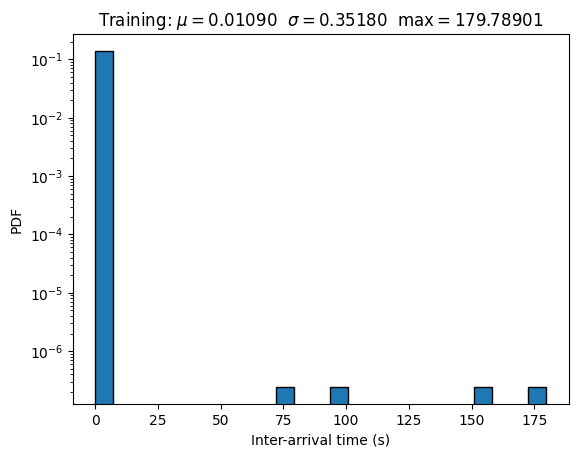

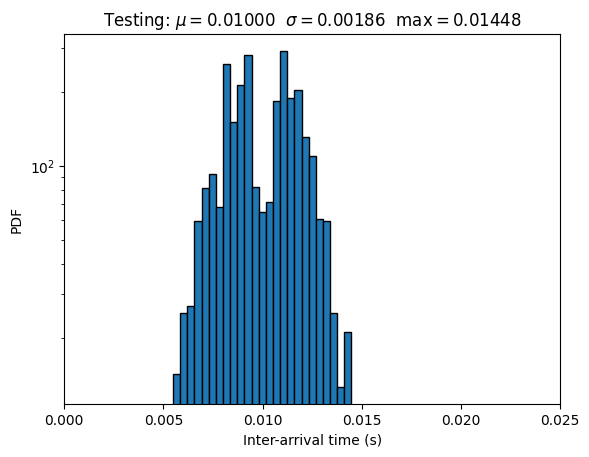

In [39]:
# print("aids: ", df_training.aid.unique())

aid = 208 # 208 1760
method = "gauss" # gauss kde

## Training

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
max_val = max(vals)

# print(type(vals), type(vals[0]), len(vals), vals)
# print("mu: ", training_dict[aid]["mu"], mu)
# print("std: ", training_dict[aid]["std"], std)
# print("max: ", max_val)
# print(pdf)

new_model = scipy.stats.norm(loc=mu, scale=std)

fig, ax = plt.subplots(1, 1)

#ax.hist(vals, bins=np.arange(0, 0.2, 0.001), density=True)
ax.hist(vals, bins=25, edgecolor="black", density=True)
#ax.plot(vals, pdf, "k", lw=2, alpha=0.6)
# ax.plot(vals, new_model.pdf(vals), "r", lw=2, alpha=0.6)
ax.set_yscale("log", nonpositive="clip")
# ax.set_xlim(xmin=0, xmax=0.025)

plt.xlabel('Inter-arrival time (s)')
plt.ylabel('PDF')
plt.title("Training:" + " " + r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

plt.show()

# ## Testing

df_aux = df_aggregation[0][df_aggregation[0].aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals)

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
max_val = max(vals)

# print(type(vals), type(vals[0]), len(vals), vals)
# print("mu: ", training_dict[aid]["mu"], mu)
# print("std: ", training_dict[aid]["std"], std)
# print("max: ", max_val)
# print(pdf)

new_model = scipy.stats.norm(loc=mu, scale=std)

fig, ax = plt.subplots(1, 1)

ax.hist(vals, bins=25, edgecolor="black", density=True)
#ax.hist(vals, bins=np.arange(0, 0.2, 0.001), density=True)
ax.set_yscale("log", nonpositive="clip")

# ax.plot(vals, pdf, "k", lw=2, alpha=0.6)
# ax.plot(vals, new_model.pdf(vals), "r", lw=2, alpha=0.6)
ax.set_xlim(xmin=0, xmax=0.025)

plt.xlabel('Inter-arrival time (s)')
plt.ylabel('PDF')
plt.title("Testing:" + " " + r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

plt.show()

## Training distributions

## 208

outliers:  58 0.010162476981113562


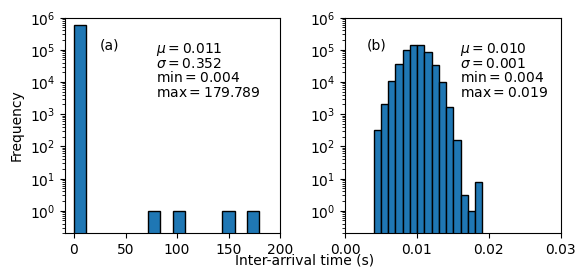

In [40]:
aid = 208

fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)

axes[0].hist(vals, bins=15, edgecolor="black")
axes[0].set_yscale("log", nonpositive="clip")
axes[0].set_xticks(np.arange(0, 250, 50))
axes[0].set_ylim([0.2, 10**6])
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
axes[0].set_ylabel('Frequency')
axes[0].text(80, 8*10**4, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0].text(80, 2.7*10**4, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0].text(80, 1*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0].text(80, 3.5*10**3, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0].annotate("(a)", xy=(25, 10**5))
#axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")

###

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)


axes[1].hist(vals, bins=15, edgecolor="black")
axes[1].set_yscale("log", nonpositive="clip")
axes[1].set_xticks(np.arange(0, 0.04, 0.01))
axes[1].set_ylim([0.2, 10**6])
# axes[0].set_xticks(np.arange(0, 250, 50))
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[1].text(0.016, 8*10**4, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1].text(0.016, 2.7*10**4, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1].text(0.016, 1*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1].text(0.016, 3.5*10**3, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1].annotate("(b)", xy=(0.003, 10**5))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

fig.text(0.5, 0.00, "Inter-arrival time (s)", ha="center")

#plt.savefig("../../figs/training_distributions_208.pdf", dpi=200, bbox_inches="tight")

plt.show()

## Fitting 208

outliers:  58 0.010162476981113562


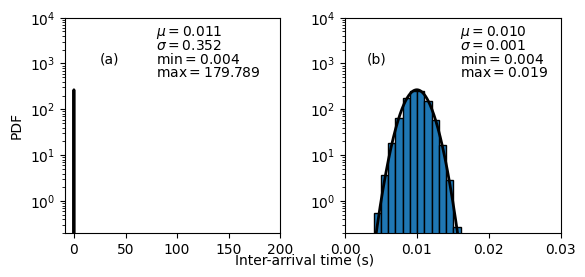

In [41]:
aid = 208
method = "gauss" # gauss, kde

fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)

axes[0].hist(vals, bins=15, density=True, edgecolor="black")
axes[0].plot(vals, pdf, "k-", lw=2)
axes[0].set_yscale("log", nonpositive="clip")
axes[0].set_xticks(np.arange(0, 250, 50))
axes[0].set_ylim([0.2, 10**4])
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
axes[0].set_ylabel('PDF')
axes[0].text(80, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0].text(80, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0].text(80, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0].text(80, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0].annotate("(a)", xy=(25, 10**3))
#axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")


###

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]
pdf = training_dict[aid][method].pdf(vals) 

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

axes[1].hist(vals, bins=15, density=True, edgecolor="black")
axes[1].plot(vals, pdf, "k-", lw=2)
axes[1].set_yscale("log", nonpositive="clip")
axes[1].set_xticks(np.arange(0, 0.04, 0.01))
axes[1].set_ylim([0.2, 10**4])
# axes[0].set_xticks(np.arange(0, 250, 50))
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[1].text(0.016, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1].text(0.016, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1].text(0.016, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1].text(0.016, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1].annotate("(b)", xy=(0.003, 10**3))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

fig.text(0.5, 0.00, "Inter-arrival time (s)", ha="center")

#plt.savefig("../../figs/training_distributions_208_fit.pdf", dpi=200, bbox_inches="tight")

plt.show()

## 1760

outliers:  64 0.010068909096630062


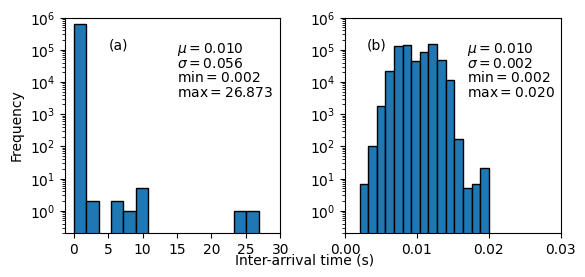

In [42]:
aid = 1760

fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)


axes[0].hist(vals, bins=15, edgecolor="black")
axes[0].set_yscale("log", nonpositive="clip")
axes[0].set_xticks(np.arange(0, 35, 5))
axes[0].set_ylim([0.2, 10**6])
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

# # axes[0].set_xlabel('Inter-arrival time (s)')
axes[0].set_ylabel('Frequency')
axes[0].text(15, 8*10**4, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0].text(15, 2.7*10**4, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0].text(15, 1*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0].text(15, 3.5*10**3, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0].annotate("(a)", xy=(5, 10**5))
# #axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")

###

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

axes[1].hist(vals, bins=15, edgecolor="black")
axes[1].set_yscale("log", nonpositive="clip")
axes[1].set_xticks(np.arange(0, 0.04, 0.01))
axes[1].set_ylim([0.2, 10**6])
# # axes[0].set_xticks(np.arange(0, 250, 50))
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[1].text(0.017, 8*10**4, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1].text(0.017, 2.7*10**4, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1].text(0.017, 1*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1].text(0.017, 3.5*10**3, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1].annotate("(b)", xy=(0.003, 10**5))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

fig.text(0.5, 0.00, "Inter-arrival time (s)", ha="center")

# plt.savefig("../../figs/training_distributions_1760.pdf", dpi=200, bbox_inches="tight")
plt.show()

## Fitting 1760

outliers:  64 0.010068909096630062


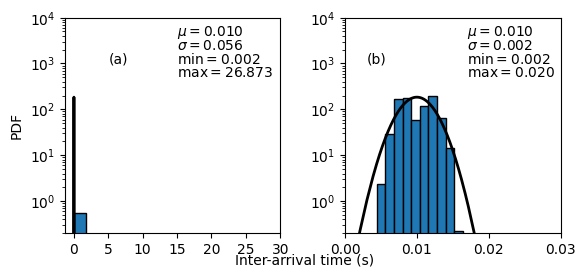

In [43]:
aid = 1760
method = "gauss"

fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)


axes[0].hist(vals, bins=15, density=True, edgecolor="black")
axes[0].plot(vals, pdf, "k-", lw=2)
axes[0].set_yscale("log", nonpositive="clip")
axes[0].set_xticks(np.arange(0, 35, 5))
#axes[0].set_xlim([0, 2])
axes[0].set_ylim([0.2, 10**4])
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

axes[0].set_ylabel('PDF')
axes[0].text(15, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0].text(15, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0].text(15, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0].text(15, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0].annotate("(a)", xy=(5, 10**3))
# #axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")

##

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]
pdf = training_dict[aid][method].pdf(vals) 

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

axes[1].hist(vals, bins=15, density=True, edgecolor="black")
axes[1].plot(vals, pdf, "k-", lw=2)
axes[1].set_yscale("log", nonpositive="clip")
axes[1].set_xticks(np.arange(0, 0.04, 0.01))
axes[1].set_ylim([0.2, 10**4])
# # axes[0].set_xticks(np.arange(0, 250, 50))
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[1].text(0.017, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1].text(0.017, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1].text(0.017, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1].text(0.017, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1].annotate("(b)", xy=(0.003, 10**3))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

fig.text(0.5, 0.00, "Inter-arrival time (s)", ha="center")

# plt.savefig("../../figs/training_distributions_1760_fit.pdf", dpi=200, bbox_inches="tight")
plt.show()

## Fitting 208 and 1760

outliers:  58 0.010162476981113562
outliers:  64 0.010068909096630062


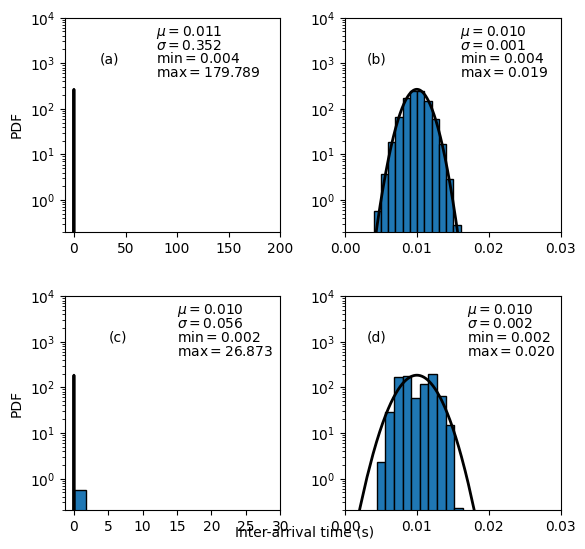

In [44]:
aid = 208
method = "gauss" # gauss, kde

fig, axes = plt.subplots(2, 2, figsize=(6.4, 6.4)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3, hspace=0.3)

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)

axes[0][0].hist(vals, bins=15, density=True, edgecolor="black")
axes[0][0].plot(vals, pdf, "k-", lw=2)
axes[0][0].set_yscale("log", nonpositive="clip")
axes[0][0].set_xticks(np.arange(0, 250, 50))
axes[0][0].set_ylim([0.2, 10**4])
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
axes[0][0].set_ylabel('PDF')
axes[0][0].text(80, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0][0].text(80, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0][0].text(80, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0][0].text(80, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0][0].annotate("(a)", xy=(25, 10**3))
#axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]
pdf = training_dict[aid][method].pdf(vals) 

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

axes[0][1].hist(vals, bins=15, density=True, edgecolor="black")
axes[0][1].plot(vals, pdf, "k-", lw=2)
axes[0][1].set_yscale("log", nonpositive="clip")
axes[0][1].set_xticks(np.arange(0, 0.04, 0.01))
axes[0][1].set_ylim([0.2, 10**4])
# axes[0].set_xticks(np.arange(0, 250, 50))
# ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[0][1].text(0.016, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0][1].text(0.016, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0][1].text(0.016, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0][1].text(0.016, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[0][1].annotate("(b)", xy=(0.003, 10**3))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

###########

aid = 1760

df_aux = df_training[df_training.aid == aid]
vals = np.sort(df_aux.time_diffs.values)
pdf = training_dict[aid][method].pdf(vals) 

mu = df_aux.time_diffs.mean()
std = df_aux.time_diffs.std() 
min_val = min(vals)
max_val = max(vals)

axes[1][0].hist(vals, bins=15, density=True, edgecolor="black")
axes[1][0].plot(vals, pdf, "k-", lw=2)
axes[1][0].set_yscale("log", nonpositive="clip")
axes[1][0].set_xticks(np.arange(0, 35, 5))
#axes[0].set_xlim([0, 2])
axes[1][0].set_ylim([0.2, 10**4])
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

axes[1][0].set_ylabel('PDF')
axes[1][0].text(15, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1][0].text(15, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1][0].text(15, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1][0].text(15, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1][0].annotate("(c)", xy=(5, 10**3))
# #axes[0].set_title(r"$\mu=$" + f"{mu:.2f}" + "  " + r"$\sigma=$" + f"{std:.2f}" + "  " + r"max$=$" + f"{max_val:.2f}")

# identify outliers in the dataset
ee = EllipticEnvelope(contamination=0.0001, support_fraction=0.999) # support_fraction=0.99
inliers = ee.fit_predict(vals.reshape(-1, 1))

# select all rows that are not outliers
mask = inliers != -1
outliers = sum(mask == False)
print("outliers: ", outliers, 100*outliers/len(vals))

vals = vals[mask]
pdf = training_dict[aid][method].pdf(vals) 

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

axes[1][1].hist(vals, bins=15, density=True, edgecolor="black")
axes[1][1].plot(vals, pdf, "k-", lw=2)
axes[1][1].set_yscale("log", nonpositive="clip")
axes[1][1].set_xticks(np.arange(0, 0.04, 0.01))
axes[1][1].set_ylim([0.2, 10**4])
# # axes[0].set_xticks(np.arange(0, 250, 50))
# # ax.set_yticks(np.arange(0, 1.25, 0.25))

# axes[0].set_xlabel('Inter-arrival time (s)')
# axes[0].set_ylabel('Frequency')
axes[1][1].text(0.017, 4*10**3, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1][1].text(0.017, 2*10**3, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1][1].text(0.017, 1*10**3, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1][1].text(0.017, 5*10**2, r"max$=$" + f"{max_val:.3f}", color="black")
axes[1][1].annotate("(d)", xy=(0.003, 10**3))
# plt.title(r"$\mu=$" + f"{mu:.5f}" + "  " + r"$\sigma=$" + f"{std:.5f}" + "  " + r"max$=$" + f"{max_val:.5f}")

fig.text(0.5, 0.07, "Inter-arrival time (s)", ha="center")

plt.savefig("../../figs/training_distributions_fit_combined.pdf", dpi=200, bbox_inches="tight")

plt.show()

## Testing distributions

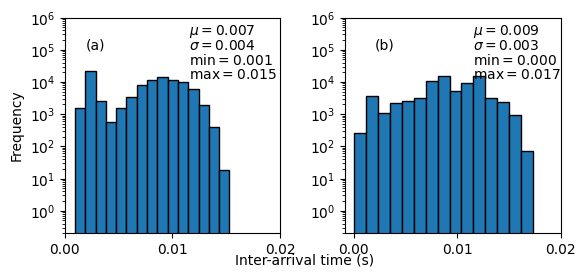

In [45]:
##

aid = 208 # 1760 1255

fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

df_aux = pd.concat(df_aggregation)
df_aux = df_aux[df_aux.aid == aid]
vals = np.sort(df_aux.time_diffs.values)

mu = vals.mean()
std = vals.std() 
max_val = max(vals)
min_val = min(vals)

# print(type(vals), type(vals[0]), len(vals), vals)
# print("mu: ", training_dict[aid]["mu"], mu)
# print("std: ", training_dict[aid]["std"], std)
# print("max: ", max_val)
# print(pdf)

axes[0].hist(vals, bins=15, edgecolor="black")
axes[0].set_yscale("log", nonpositive="clip")
axes[0].set_xticks(np.arange(0, 0.026, 0.01))
axes[0].set_ylim([0.2, 10**6])
axes[0].annotate("(a)", xy=(0.002, 10**5))

axes[0].set_ylabel('Frequency')
axes[0].text(0.0115, 3*10**5, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[0].text(0.0115, 1*10**5, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[0].text(0.0115, 3.5*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[0].text(0.0115, 1.3*10**4, r"max$=$" + f"{max_val:.3f}", color="black")

###

aid = 1760

df_aux = pd.concat(df_aggregation)
df_aux = df_aux[df_aux.aid == aid]
vals = np.sort(df_aux.time_diffs.values)

mu = vals.mean()
std = vals.std() 
min_val = min(vals)
max_val = max(vals)

# print(type(vals), type(vals[0]), len(vals), vals)
# print("mu: ", training_dict[aid]["mu"], mu)
# print("std: ", training_dict[aid]["std"], std)
# print("max: ", max_val)
# print(pdf)

axes[1].hist(vals, bins=15, edgecolor="black")
axes[1].set_yscale("log", nonpositive="clip")
axes[1].set_xticks(np.arange(0, 0.026, 0.01))
axes[1].set_ylim([0.2, 10**6])
axes[1].annotate("(b)", xy=(0.002, 10**5))

axes[1].text(0.0115, 3*10**5, r"$\mu=$" + f"{mu:.3f}", color="black")
axes[1].text(0.0115, 1*10**5, r"$\sigma=$" + f"{std:.3f}", color="black")
axes[1].text(0.0115, 3.5*10**4, r"min$=$" + f"{min_val:.3f}", color="black")
axes[1].text(0.0115, 1.3*10**4, r"max$=$" + f"{max_val:.3f}", color="black")

fig.text(0.5, 0.00, "Inter-arrival time (s)", ha="center")

plt.savefig("../../figs/testing_distributions.pdf", dpi=200, bbox_inches="tight")

plt.show()

## ROC/PRC Curves

0.0 nan
0.05555555555555555 nan
0.1111111111111111 0.002821514861599831
0.16666666666666666 0.0038689667300836144
0.2222222222222222 0.7875471003613046
0.2777777777777778 0.7980271932602165
0.3333333333333333 0.9547507541540974
0.38888888888888884 0.9561107921690005
0.4444444444444444 0.9862231020552685
0.5 0.9846420629249926
0.5555555555555556 0.9761170787516683
0.611111111111111 0.9530650077953507
0.6666666666666666 0.9308103685972698
0.7222222222222222 0.901628157811709
0.7777777777777777 0.8816506916145326
0.8333333333333333 0.7412084697822245
0.8888888888888888 0.6448204401773301
0.9444444444444444 0.39370315802959455
1.0 0.0911718999530905


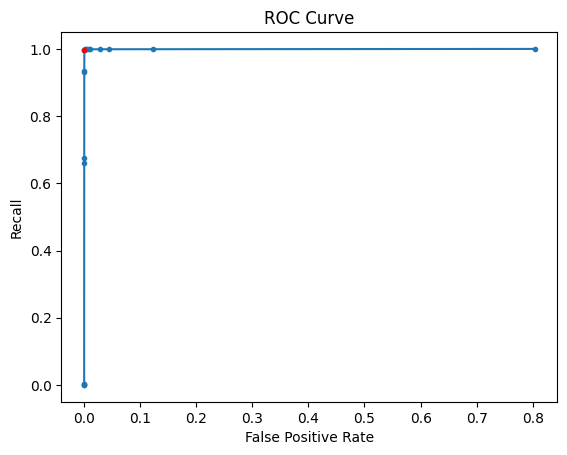

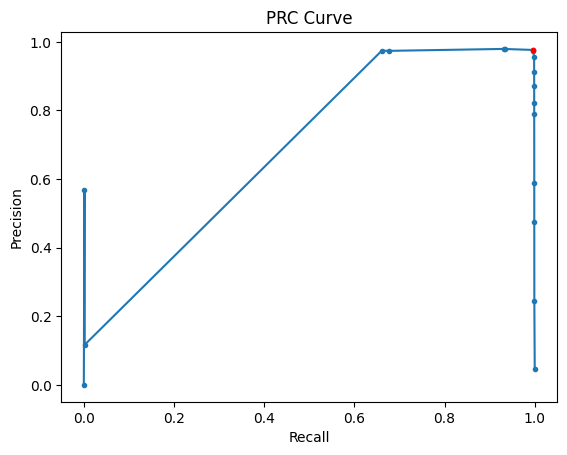

confusion matrix: 
 [[1525274    1473]
 [    239   61277]]
precision:  0.9765258964143426
recall:  0.9961148319136485
f1 score:  0.9862231020552685
false positive rate 0.0009647963939015436


In [46]:
pvals_mean = np.linspace(0, 1, 19)
# print(len(pvals_mean), pvals_mean)

for pval in pvals_mean:
    print(pval, results_mean_final[pval]["f1"])
    
optimum = 0.4444444444444444

## Generate ROC curve
x_roc_mean = [results_mean_final[p]['false_pos'] for p in pvals_mean]
y_roc_mean = [results_mean_final[p]['recall'] for p in pvals_mean]

plt.plot(x_roc_mean, y_roc_mean, '.-')
plt.plot(results_mean_final[optimum]['false_pos'], results_mean_final[optimum]['recall'], '.-r')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')

plt.show()
    
# Can use this dictionary to generate PRC curve
x_prc_mean = [results_mean_final[p]['recall'] for p in pvals_mean]
y_prc_mean = [results_mean_final[p]['prec'] for p in pvals_mean]

# print(x_roc_kde, y_roc_kde)
plt.plot(x_prc_mean, y_prc_mean, '.-')
plt.plot(results_mean_final[optimum]['recall'], results_mean_final[optimum]['prec'], '.-r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve')

plt.show()


print("confusion matrix: \n", results_mean_final[optimum]["cm"])
print("precision: ", results_mean_final[optimum]["prec"])
print("recall: ", results_mean_final[optimum]["recall"])
print("f1 score: ", results_mean_final[optimum]["f1"])
print("false positive rate", results_mean_final[optimum]["false_pos"])

# print("confusion matrix: \n", results_mean_final["total"]["cm"])
# print("precision: ", results_mean_final["total"]["prec"])
# print("recall: ", results_mean_final["total"]["recall"])
# print("f1 score: ", results_mean_final["total"]["f1"])
# print("false positive rate", results_mean_final["total"]["false_pos"])

In [47]:
# training_dict
# df_aggregation[0]

## Method 4: Binning

In [48]:
reload(helper_functions)

# # The above dictionary informed our decision for how to write our alert_by_bin function
# # Now we get results using that function
helper_functions.get_results_binning(df_aggregation, training_dict, 6) # 10 seconds

helper_functions.get_results_binning_various_p(df_aggregation, training_dict, 6) # 10 seconds

results_binning_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_binning_final.pkl") 

 62%|██████▎   | 10/16 [00:02<00:01,  3.33it/s]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:785: RuntimeWarning: invalid value encountered in scalar divide
  results_binning[i+1]['prec'] = results_binning[i+1]['cm'][1,1]/(results_binning[i+1]['cm'][1,1]+results_binning[i+1]['cm'][0,1])
  0%|          | 0/19 [00:00<?, ?it/s]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:821: RuntimeWarning: invalid value encountered in scalar divide
  results_binning_final[p]['f1'] = 2*((results_binning_final[p]['prec']*results_binning_final[p]['recall'])/(results_binning_final[p]['prec']+results_binning_final[p]['recall']))
  5%|▌         | 1/19 [00:04<01:28,  4.91s/it]/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/code/helper_functions.py:821: RuntimeWarning: invalid value encountered in scalar divide
  results_binning_final[p]['f1'] = 2*((results_binning_final[p]['prec']*resu

1.0 nan
1.5 nan
2.0 nan
2.5 0.013244821753422908
3.0 0.6583461658572306
3.5 0.9889276161141283
4.0 0.9886859258067112
4.5 0.987513258123614
5.0 0.9852749032087404
5.5 0.9572018959116487
6.0 0.12249839939381087
6.5 0.0750355874707707
7.0 0.07499935991767931
7.5 0.07495407897502444
8.0 0.07495357666795012
8.5 0.07495330268511084
9.0 0.07495330268511084
9.5 0.0749530743676082
10.0 0.0749530743676082


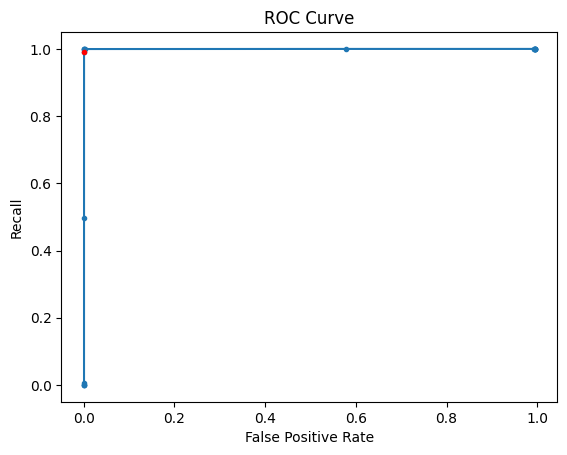

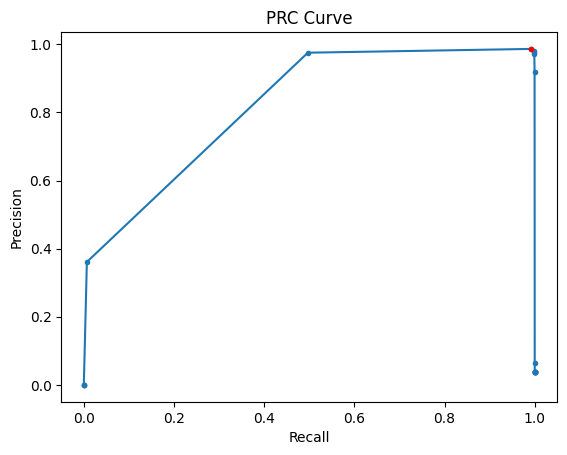

confusion matrix: 
 [[1525895     852]
 [    514   61002]]
precision:  0.9862256280919585
recall:  0.9916444502243319
f1 score:  0.9889276161141283
false positive rate 0.0005580492380204447


In [49]:
pvals_binning = np.linspace(1, 10, 19) # 0, 4
# print(len(pvals_binning), pvals_binning)

for pval in pvals_binning:
    print(pval, results_binning_final[pval]["f1"])
    
optimum = 3.5

## Generate ROC curve
x_roc_binning = [results_binning_final[p]['false_pos'] for p in pvals_binning]
y_roc_binning = [results_binning_final[p]['recall'] for p in pvals_binning]

plt.plot(x_roc_binning, y_roc_binning, '.-')
plt.plot(results_binning_final[optimum]['false_pos'], results_binning_final[optimum]['recall'], '.-r')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')

plt.show()


# Can use this dictionary to generate PRC curve
x_prc_binning = [results_binning_final[p]['recall'] for p in pvals_binning]
y_prc_binning = [results_binning_final[p]['prec'] for p in pvals_binning]

# print(x_roc_kde, y_roc_kde)
plt.plot(x_prc_binning, y_prc_binning, '.-')
plt.plot(results_binning_final[optimum]['recall'], results_binning_final[optimum]['prec'], '.-r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve')

plt.show()


print("confusion matrix: \n", results_binning_final[optimum]["cm"])
print("precision: ", results_binning_final[optimum]["prec"])
print("recall: ", results_binning_final[optimum]["recall"])
print("f1 score: ", results_binning_final[optimum]["f1"])
print("false positive rate", results_binning_final[optimum]["false_pos"])

# print("confusion matrix: \n", results_binning_final["total"]["cm"])
# print("precision: ", results_binning_final["total"]["prec"])
# print("recall: ", results_binning_final["total"]["recall"])
# print("f1 score: ", results_binning_final["total"]["f1"])
# print("false positive rate", results_binning_final["total"]["false_pos"])

In [50]:
df_aggregation[0]

,time,aid,data,time_diffs,actual_attack,predicted_attack,alert_window
3873,1.618163,6,0800006400000000,0.999845,False,True,False
6266,2.618064,6,0800006400000000,0.999901,False,True,False
8655,3.617806,6,0800006400000000,0.999742,False,True,False
11049,4.617810,6,0800006400000000,1.000004,False,True,False
13441,5.618164,6,0800006400000000,1.000354,False,True,False
...,...,...,...,...,...,...,...
80160,32.636582,1788,00000738D2B85800,0.099969,False,True,True
80402,32.736450,1788,0000073732B86000,0.099868,False,True,True
80641,32.836612,1788,0000073892B86800,0.100162,False,False,True
80874,32.936532,1788,00000737B2B87000,0.099920,False,True,True


## Method 3: Gaussian

In [51]:
reload(helper_functions)

with open("capture_metadata.json", "r") as read_file:
    attack_dict = json.load(read_file)

count = 0
for file_name in tqdm(os.listdir(".")):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
    # if "masquerade" not in file_name and "accelerator" not in file_name and "fuzzing" not in file_name and "metadata" not in file_name:
        print(file_name)
        
        # print(attack_dict[file_name[:-4]]["injection_id"], int(attack_dict[file_name[:-4]]["injection_id"], 16), attack_dict[file_name[:-4]]["injection_data_str"])
        
        # Adds column to df with the value of the Guassian approximation at each time_diff in the df
        df_aggregation[count] = helper_functions.add_gauss_val_col(df_aggregation[count], training_dict)                                                   
        
        count += 1

  0%|          | 0/36 [00:00<?, ?it/s]

correlated_signal_attack_1.log


  6%|▌         | 2/36 [00:00<00:03,  8.69it/s]

correlated_signal_attack_3.log


 11%|█         | 4/36 [00:00<00:02, 12.04it/s]

correlated_signal_attack_2.log


 19%|█▉        | 7/36 [00:00<00:01, 16.30it/s]

reverse_light_off_attack_1.log


 25%|██▌       | 9/36 [00:00<00:01, 16.55it/s]

max_speedometer_attack_1.log


 31%|███       | 11/36 [00:00<00:01, 14.85it/s]

reverse_light_off_attack_2.log


100%|██████████| 105/105 [00:00<00:00, 911.26it/s]


max_speedometer_attack_3.log


 36%|███▌      | 13/36 [00:01<00:02, 11.07it/s]

max_speedometer_attack_2.log


100%|██████████| 105/105 [00:00<00:00, 847.19it/s]


reverse_light_off_attack_3.log


 42%|████▏     | 15/36 [00:01<00:02,  9.53it/s]

max_engine_coolant_temp_attack.log


 50%|█████     | 18/36 [00:01<00:01, 12.62it/s]

fuzzing_attack_3.log


 56%|█████▌    | 20/36 [00:01<00:01, 11.98it/s]

fuzzing_attack_2.log


 61%|██████    | 22/36 [00:01<00:01, 13.29it/s]

fuzzing_attack_1.log


 67%|██████▋   | 24/36 [00:01<00:00, 14.04it/s]

reverse_light_on_attack_2.log


 94%|█████████▍| 34/36 [00:02<00:00, 29.76it/s]

reverse_light_on_attack_3.log


100%|██████████| 105/105 [00:00<00:00, 833.34it/s]


reverse_light_on_attack_1.log


100%|██████████| 36/36 [00:02<00:00, 15.72it/s]


In [52]:
df_aggregation[0]

,time,aid,data,time_diffs,actual_attack,predicted_attack,alert_window,gauss_val
3873,1.618163,6,0800006400000000,0.999845,False,True,False,0.805948
6266,2.618064,6,0800006400000000,0.999901,False,True,False,0.805951
8655,3.617806,6,0800006400000000,0.999742,False,True,False,0.805943
11049,4.617810,6,0800006400000000,1.000004,False,True,False,0.805956
13441,5.618164,6,0800006400000000,1.000354,False,True,False,0.805974
...,...,...,...,...,...,...,...,...
80160,32.636582,1788,00000738D2B85800,0.099969,False,True,True,50.935230
80402,32.736450,1788,0000073732B86000,0.099868,False,True,True,50.920565
80641,32.836612,1788,0000073892B86800,0.100162,False,False,True,50.939715
80874,32.936532,1788,00000737B2B87000,0.099920,False,True,True,50.929171


In [53]:
reload(helper_functions)

# Decide which pvalues to test with the Gaussain approximation
pvals_gauss = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0.01, 0.1, 0.01)))
print(pvals_gauss)


# pvals_gauss = list(np.arange(0.0001, 0.0011, 0.0001))
# print(pvals_gauss)

# # Fill each 'y_thresholds_gauss' dictionary with p values and their corresponding y_thresholds
# # After this has been done once, we don't need to do it again since it has been pickled.
# # Commenting out the code to avoid rewriting the data we have.

for aid in tqdm(df_training.aid.unique()):
    
    training_dict[aid]['y_thresholds_gauss'] = {}
    for p in pvals_gauss:
        helper_functions.y_threshold_gauss(training_dict, aid, p)
        
# helper_functions.picklify(training_dict, os.path.dirname(os.getcwd()) + "/training_dict.pkl")

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09]


100%|██████████| 105/105 [06:50<00:00,  3.91s/it]


In [54]:
helper_functions.picklify(training_dict, os.path.dirname(os.getcwd()) + "/training_dict.pkl")
training_dict[37]

{'mu': 0.8426860569506046,
 'std': 0.5836586794325013,
 'kde': <scipy.stats._kde.gaussian_kde at 0x1649366a0>,
 'gauss': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x164936550>,
 'y_thresholds_kde': {},
 'y_thresholds_gauss': {0.001: 0.002951329261013771,
  0.002: 0.005597139512045847,
  0.003: 0.008304567509713708,
  0.004: 0.01080550434441636,
  0.005: 0.013186659384074765,
  0.006: 0.015580274605751654,
  0.007: 0.01785450158053402,
  0.008: 0.019874860980363382,
  0.009000000000000001: 0.022088468075950583,
  0.01: 0.02450937422545548,
  0.02: 0.0452772937823028,
  0.03: 0.06350100076271627,
  0.04: 0.08189645175594176,
  0.05: 0.1001286306412247,
  0.060000000000000005: 0.11457225429138052,
  0.06999999999999999: 0.13045856487604657,
  0.08: 0.14524989397991508,
  0.09: 0.1611371177900055}}

In [55]:
df_aggregation[0]

,time,aid,data,time_diffs,actual_attack,predicted_attack,alert_window,gauss_val
3873,1.618163,6,0800006400000000,0.999845,False,True,False,0.805948
6266,2.618064,6,0800006400000000,0.999901,False,True,False,0.805951
8655,3.617806,6,0800006400000000,0.999742,False,True,False,0.805943
11049,4.617810,6,0800006400000000,1.000004,False,True,False,0.805956
13441,5.618164,6,0800006400000000,1.000354,False,True,False,0.805974
...,...,...,...,...,...,...,...,...
80160,32.636582,1788,00000738D2B85800,0.099969,False,True,True,50.935230
80402,32.736450,1788,0000073732B86000,0.099868,False,True,True,50.920565
80641,32.836612,1788,0000073892B86800,0.100162,False,False,True,50.939715
80874,32.936532,1788,00000737B2B87000,0.099920,False,True,True,50.929171


In [56]:
reload(helper_functions)

# training_dict = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/training_dict.pkl") 
# helper_functions.get_results_gauss(df_aggregation, training_dict)

results_gauss_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_gauss_final.pkl") 

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jamescourson/Documents/GAN_play/ids/can-time-based-ids-benchmark/data/results_gauss_final.pkl'

In [ ]:
pvals_gauss = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0.01, 0.1, 0.01)))
# print(pvals_gauss)

for pval in pvals_gauss:
    print(pval, results_gauss_final[pval]["f1"])
    
optimum = 0.09

## Generate ROC curve
x_roc_gauss = [results_gauss_final[p]['false_pos'] for p in pvals_gauss]
y_roc_gauss = [results_gauss_final[p]['recall'] for p in pvals_gauss]

plt.plot(x_roc_gauss, y_roc_gauss, '.-')
plt.plot(results_gauss_final[optimum]['false_pos'], results_gauss_final[optimum]['recall'], '.-r')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')

plt.show()

# Can use this dictionary to generate PRC curve
x_prc_gauss = [results_gauss_final[p]['recall'] for p in pvals_gauss]
y_prc_gauss = [results_gauss_final[p]['prec'] for p in pvals_gauss]

# print(x_roc_kde, y_roc_kde)
plt.plot(x_prc_gauss, y_prc_gauss, '.-')
plt.plot(results_gauss_final[optimum]['recall'], results_gauss_final[optimum]['prec'], '.-r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve')

plt.show()

print("confusion matrix: \n", results_gauss_final[optimum]["cm"])
print("precision: ", results_gauss_final[optimum]["prec"])
print("recall: ", results_gauss_final[optimum]["recall"])
print("f1 score: ", results_gauss_final[optimum]["f1"])
print("false positive rate", results_gauss_final[optimum]["false_pos"])

## Total Statistics

In [ ]:
print(100*np.array(pvals_gauss))

count = 0
total = 0
for df in df_aggregation:
    count += np.sum(df.actual_attack.values)
    total += df.shape[0]
    
print("attacks: ", count)
print("benign: ", total-count)
print("total: ", total)

## Method 2: KDE

In [ ]:
reload(helper_functions)

with open("capture_metadata.json", "r") as read_file:
    attack_dict = json.load(read_file)

count = 0
for file_name in tqdm(os.listdir(".")):
    
    if "masquerade" not in file_name and "accelerator" not in file_name and "metadata" not in file_name:
    # if "masquerade" not in file_name and "accelerator" not in file_name and "fuzzing" not in file_name and "metadata" not in file_name:
        print(file_name)
        
        # print(attack_dict[file_name[:-4]]["injection_id"], int(attack_dict[file_name[:-4]]["injection_id"], 16), attack_dict[file_name[:-4]]["injection_data_str"])
    
        # Add column to each attack dataframe to indicate attack the gaussian corresponding value
        df_aggregation[count] = helper_functions.add_kde_val_col(df_aggregation[count], training_dict)                                                   
        
        count += 1

In [ ]:
df_aggregation[0]

In [ ]:
# helper_functions.picklify(df_aggregation, os.path.dirname(os.getcwd()) + "/df_aggregation_final.pkl")

df_aggregation = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/df_aggregation_final.pkl") 

df_aggregation[0]

In [ ]:
# Fill this list with the pvals we want to find y_thresholds for
pvals_kde = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0, 0.1, 0.01)))
print(pvals_kde)

In [ ]:
#training_dict

In [ ]:
# reload(helper_functions)

# # Fill each 'y_thresholds_kde' dictionary with p values and their corresponding y_thresholds
# # Once this has been done, results are pickled and don't need to be re-run.
# # Will comment this out to avoid overwriting
# #cc = 0
# for aid in tqdm(df_training.aid.unique()):
#     #cc += 1
#     #print (f'aid {cc} of 128')
#     for p in pvals_kde:
#         helper_functions.y_threshold_kde(training_dict, aid, p)
        
# helper_functions.picklify(training_dict, os.path.dirname(os.getcwd()) + "/training_dict.pkl")

In [ ]:
training_dict = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/training_dict.pkl") 

In [ ]:
#training_dict
#df_aggregation[0]

In [ ]:
# reload(helper_functions)
# helper_functions.get_results_kde(pvals_kde, df_aggregation, training_dict)

In [ ]:
results_kde_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_kde_final.pkl") 

In [ ]:
pvals_kde = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0, 0.1, 0.01)))
# print(pvals_kde)

for pval in pvals_kde:
    print(pval, results_kde_final[pval]["f1"])
    
optimum = 0.09

#Can use this dictionary to generate ROC curve
x_roc_kde = [results_kde_final[p]['false_pos'] for p in pvals_kde]
y_roc_kde = [results_kde_final[p]['recall'] for p in pvals_kde]

# print(x_roc_kde, y_roc_kde)
plt.plot(x_roc_kde, y_roc_kde, '.-')
plt.plot(results_kde_final[optimum]['false_pos'], results_kde_final[optimum]['recall'], '.-r')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')

plt.show()

# Can use this dictionary to generate PRC curve
x_prc_kde = [results_kde_final[p]['recall'] for p in pvals_kde]
y_prc_kde = [results_kde_final[p]['prec'] for p in pvals_kde]

# print(x_roc_kde, y_roc_kde)
plt.plot(x_prc_kde, y_prc_kde, '.-')
plt.plot(results_kde_final[optimum]['recall'], results_kde_final[optimum]['prec'], '.-r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve')

plt.show()

print("confusion matrix: \n", results_kde_final[optimum]["cm"])
print("precision: ", results_kde_final[optimum]["prec"])
print("recall: ", results_kde_final[optimum]["recall"])
print("f1 score: ", results_kde_final[optimum]["f1"])
print("false positive rate", results_kde_final[optimum]["false_pos"])

## Aggregated Figure

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))

ax.plot(x_prc_mean, y_prc_mean, color="#377eb8", marker="o", markersize=5, label="Mean")
# print(list(x_prc_mean))
# print(list(y_prc_mean))
print("pr auc mean: ", auc(np.nan_to_num(x_prc_mean), np.nan_to_num(y_prc_mean)))

ax.plot(x_prc_binning, y_prc_binning, color="#ff7f00", marker="s", markersize=5, label="Binning")
print("pr auc binning: ", auc(x_prc_binning, y_prc_binning))

ax.plot(x_prc_gauss, y_prc_gauss, color="#4daf4a", marker="^", markersize=5, label="Gaussian")
print("pr auc gauss: ", auc(x_prc_gauss, y_prc_gauss))

ax.plot(x_prc_kde, y_prc_kde, color="#f781bf", marker="v", markersize=5, label="KDE")
print("pr auc kde: ", auc(x_prc_kde, y_prc_kde))

ax.plot(np.linspace(0, 1, 20), 20*[0.039], "--", color="gray", markersize=5)
ax.text(0.25, -0.05, "Baseline: 0.039", color="gray")

ax.set_xticks(np.arange(0, 1.25, 0.25))
ax.set_yticks(np.arange(0, 1.25, 0.25))

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend(loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.2),  ncol=2, fancybox=False, shadow=False, labelspacing=0.5, columnspacing=1)


#plt.savefig("../../figs/figure_prc.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
pvals_gauss = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0.01, 0.1, 0.01)))
print(len(pvals_gauss), pvals_gauss)

## Unified Figure

In [ ]:
# Without outliers

results_mean_final_no_pretraining = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_mean_final_no_pretraining.pkl") 
pvals_mean_no_pretraining = np.linspace(0, 1, 19)
x_prc_mean_no_pretraining = [results_mean_final_no_pretraining[p]['recall'] for p in pvals_mean_no_pretraining]
y_prc_mean_no_pretraining = [results_mean_final_no_pretraining[p]['prec'] for p in pvals_mean_no_pretraining]

results_binning_final_no_pretraining = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_binning_final_no_pretraining.pkl") 
pvals_binning_no_pretraining = np.linspace(1, 10, 19)
x_prc_binning_no_pretraining = [results_binning_final_no_pretraining[p]['recall'] for p in pvals_binning_no_pretraining]
y_prc_binning_no_pretraining = [results_binning_final_no_pretraining[p]['prec'] for p in pvals_binning_no_pretraining]

results_gauss_final_no_pretraining = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_gauss_final_no_pretraining.pkl")
pvals_gauss_no_pretraining = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0.01, 0.1, 0.01)))
x_prc_gauss_no_pretraining  = [results_gauss_final_no_pretraining [p]['recall'] for p in pvals_gauss_no_pretraining]
y_prc_gauss_no_pretraining  = [results_gauss_final_no_pretraining [p]['prec'] for p in pvals_gauss_no_pretraining]

results_kde_final_no_pretraining = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_kde_final_no_pretraining.pkl")
pvals_kde_no_pretraining = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0, 0.1, 0.01)))
x_prc_kde_no_pretraining  = [results_kde_final_no_pretraining [p]['recall'] for p in pvals_kde_no_pretraining]
y_prc_kde_no_pretraining  = [results_kde_final_no_pretraining [p]['prec'] for p in pvals_kde_no_pretraining]

# With outliers

results_mean_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_mean_final.pkl") 
pvals_mean = np.linspace(0, 1, 19)
x_prc_mean = [results_mean_final[p]['recall'] for p in pvals_mean]
y_prc_mean = [results_mean_final[p]['prec'] for p in pvals_mean]

results_binning_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_binning_final.pkl") 
pvals_binning = np.linspace(1, 10, 19)
x_prc_binning = [results_binning_final[p]['recall'] for p in pvals_binning]
y_prc_binning = [results_binning_final[p]['prec'] for p in pvals_binning]

results_gauss_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_gauss_final.pkl") 
pvals_gauss = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0.01, 0.1, 0.01)))
x_prc_gauss = [results_gauss_final[p]['recall'] for p in pvals_gauss]
y_prc_gauss = [results_gauss_final[p]['prec'] for p in pvals_gauss]

results_kde_final = helper_functions.unpickle(os.path.dirname(os.getcwd()) + "/results_kde_final.pkl")
pvals_kde = sorted(list(np.arange(0.001, 0.01, 0.001)) + list(np.arange(0, 0.1, 0.01)))
x_prc_kde = [results_kde_final[p]['recall'] for p in pvals_kde]
y_prc_kde = [results_kde_final[p]['prec'] for p in pvals_kde]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.8)) # figsize=(3.4, 1.7) (default: [6.4, 4.8])
fig.subplots_adjust(wspace=0.3)

axes[0].plot(x_prc_mean_no_pretraining, y_prc_mean_no_pretraining, color="#377eb8", marker="o", markersize=5, label="Mean")
# print("pr auc mean: ", auc(np.nan_to_num(x_prc_mean), np.nan_to_num(y_prc_mean)))

axes[0].plot(x_prc_binning_no_pretraining, y_prc_binning_no_pretraining, color="#ff7f00", marker="s", markersize=5, label="Binning")
# print("pr auc binning: ", auc(x_prc_binning, y_prc_binning))

axes[0].plot(x_prc_gauss_no_pretraining, y_prc_gauss_no_pretraining, color="#4daf4a", marker="^", markersize=5, label="Gaussian")
# print("pr auc gauss: ", auc(x_prc_gauss, y_prc_gauss))

axes[0].plot(x_prc_kde_no_pretraining, y_prc_kde_no_pretraining, color="#f781bf", marker="v", markersize=5, label="KDE")
# print("pr auc kde: ", auc(x_prc_kde, y_prc_kde))

axes[0].plot(np.linspace(0, 1, 20), 20*[0.039], "--", color="gray", markersize=5)
axes[0].text(0.25, -0.05, "Baseline: 0.039", color="gray")

axes[0].set_xticks(np.arange(0, 1.25, 0.25))
axes[0].set_yticks(np.arange(0, 1.25, 0.25))

axes[0].set_xlim([-0.1, 1.1])
axes[0].set_ylim([-0.1, 1.1])

#axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].annotate("(a)", xy=(0.15, 0.95))

axes[1].plot(x_prc_mean, y_prc_mean, color="#377eb8", marker="o", markersize=5, label="Mean")
# print("pr auc mean: ", auc(np.nan_to_num(x_prc_mean), np.nan_to_num(y_prc_mean)))

axes[1].plot(x_prc_binning, y_prc_binning, color="#ff7f00", marker="s", markersize=5, label="Binning")
# print("pr auc binning: ", auc(x_prc_binning, y_prc_binning))

axes[1].plot(x_prc_gauss, y_prc_gauss, color="#4daf4a", marker="^", markersize=5, label="Gaussian")
# print("pr auc gauss: ", auc(x_prc_gauss, y_prc_gauss))

axes[1].plot(x_prc_kde, y_prc_kde, color="#f781bf", marker="v", markersize=5, label="KDE")
# print("pr auc kde: ", auc(x_prc_kde, y_prc_kde))

axes[1].plot(np.linspace(0, 1, 20), 20*[0.039], "--", color="gray", markersize=5)
axes[1].text(0.25, -0.05, "Baseline: 0.039", color="gray")

axes[1].set_xticks(np.arange(0, 1.25, 0.25))
axes[1].set_yticks(np.arange(0, 1.25, 0.25))

axes[1].set_xlim([-0.1, 1.1])
axes[1].set_ylim([-0.1, 1.1])

#axes[0].set_xlabel("Recall")
#axes[1].set_ylabel("Precision")
axes[1].annotate("(b)", xy=(0.15, 0.95))

fig.text(0.5, 0.00, "Recall", ha="center")

plt.legend(loc="upper center", frameon=False, bbox_to_anchor=(-0.15, 1.2),  ncol=4, fancybox=False, shadow=False, labelspacing=0.5, columnspacing=1)

#plt.savefig("../../figs/figure_prc_condensed.pdf", dpi=200, bbox_inches="tight")

plt.show()